In [141]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [142]:
# Dataset generation
def generate_dataset(theta0 , theta1 , n , var):
    x = torch.linspace(-10 , 10 , n)
    # y = theta1*x + theta0 + torch.distributions.Normal(0 , var).sample(x.shape)
    y = theta1*x + theta0 
    return x , y

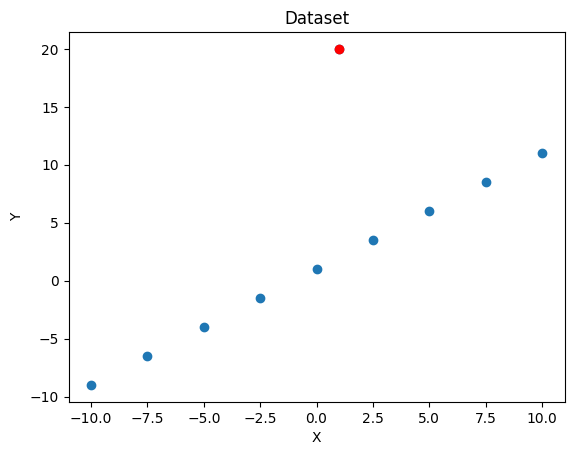

In [143]:
# Dataset generation
n = 9
var_data = 1
X , Y = generate_dataset(1 , 1 , n , var_data)

# Add an outlier
X = torch.cat((X , torch.tensor([1.])))
Y = torch.cat((Y , torch.tensor([20.])))

# Sort X and Y according to X
X , indices = torch.sort(X)
Y = Y[indices]

X = X.float()
Y = Y.float()

plt.scatter(X , Y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dataset')
plt.scatter(1, 20 , color = 'red')

In [144]:
print(X)
print(Y)

tensor([-10.0000,  -7.5000,  -5.0000,  -2.5000,   0.0000,   1.0000,   2.5000,
          5.0000,   7.5000,  10.0000])
tensor([-9.0000, -6.5000, -4.0000, -1.5000,  1.0000, 20.0000,  3.5000,  6.0000,
         8.5000, 11.0000])


In [145]:
# Make X a nx2 matrix by adding a column of ones
X = torch.stack([torch.ones(n+1) , X] , dim = 1)

In [146]:
def prior(mean , cov):
    return torch.distributions.MultivariateNormal(mean, cov)

def posterior(mean , cov):
    return torch.distributions.MultivariateNormal(mean , cov)

In [147]:
def plot_contour(dist):
    x = torch.linspace(-5, 5, 1000)
    y = torch.linspace(-5, 5, 1000)
    X, Y = torch.meshgrid(x, y)
    XY = torch.stack([X, Y], dim=-1)
    Z = torch.exp(dist.log_prob(XY))
    mean = dist.mean
    plt.contourf(X, Y, Z , levels = 20 , cmap = 'magma')
    plt.scatter(mean[0] , mean[1] , color = 'red')
    plt.text(mean[0] , mean[1] , "Mean: " + str(round(mean[0].item() , 2)) + ", " + str(round(mean[1].item() , 2)) , color = 'white')
    plt.xlabel("theta0")
    plt.ylabel("theta1")
    plt.colorbar()
    plt.show()

In [148]:
mean_prior = torch.tensor([0.0 , 0.0])
cov_prior = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
var_likelihood = 1

In [149]:
Y = Y.reshape(10 , 1)
mean_prior = mean_prior.reshape(2 , 1)

In [150]:
cov_posterior = torch.linalg.inv(torch.linalg.inv(cov_prior) + (1/var_likelihood)*torch.matmul(X.T , X))
mean_posterior = torch.matmul(cov_posterior , (torch.linalg.inv(cov_prior)@mean_prior + (1/var_likelihood)*torch.matmul(X.T , Y)))
mean_posterior = mean_posterior.reshape(2)
mean_prior = mean_prior.reshape(2)
prior_dist = prior(mean_prior , cov_prior)
posterior_dist = posterior(mean_posterior , cov_posterior)

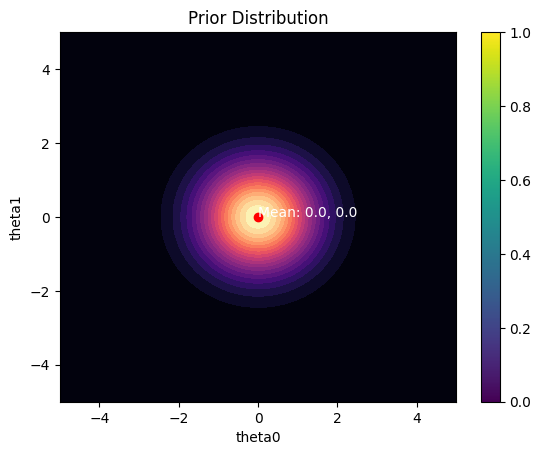

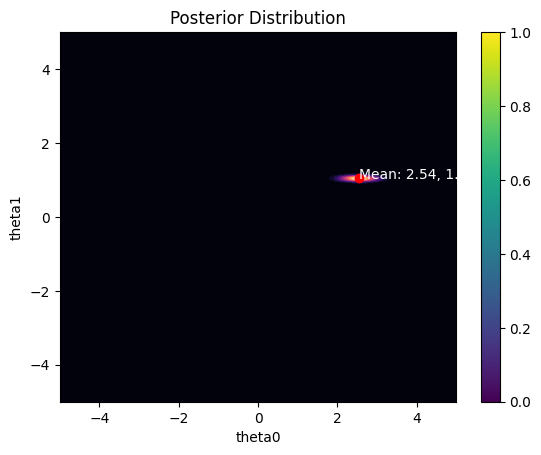

In [151]:
plt.title("Prior Distribution")
plot_contour(prior_dist)
plt.title("Posterior Distribution")
plot_contour(posterior_dist)
plt.show()

In [152]:
def predictive_dist(x , mean_pos , cov_pos , var_likelihood):
    x.reshape(1 , 2)
    mean_pos.reshape(1 , 2)
    return torch.distributions.Normal(torch.matmul(x , mean_pos.T) , var_likelihood + torch.matmul(x , torch.matmul(cov_pos , x.T)))

In [153]:
prediction_dists = []
for i in range(n+1):
    prediction_dists.append(predictive_dist(X[i] , mean_posterior , cov_posterior , var_likelihood))

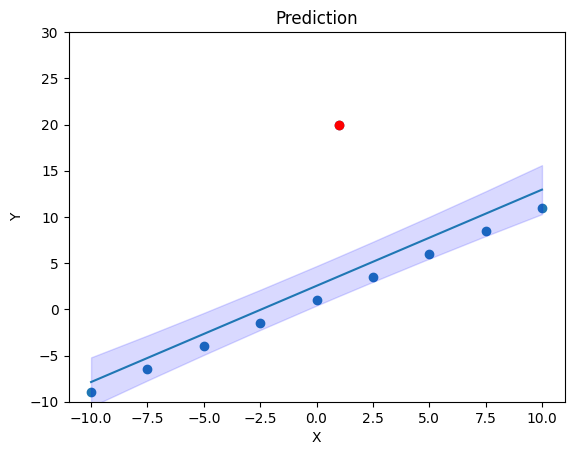

In [169]:
# Plot the prediction as a gradient with the color opacity how confident the model is
def plot_predictions(prediction_dists , X , Y):
    x_new = X[:,1]  
    plt.scatter(x_new , Y)
    plt.scatter(1, 20 , color = 'red')
    y_mean = []
    y_var = []
    for i in range(n+1):
        dist = prediction_dists[i]
        y_mean.append(dist.mean)
        y_var.append(dist.variance)

    plt.plot(x_new , y_mean )
    y_upper = []
    y_lower = []
    for i in range(n+1):
        y_upper.append((y_mean[i] + 1.96*np.sqrt(y_var[i])))
        y_lower.append((y_mean[i] - 1.96*np.sqrt(y_var[i])))
    plt.fill_between(x_new , y_upper , y_lower , color = 'blue' , alpha = 0.15)
    plt.ylim(-10, 30)
    plt.title("Prediction")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

plot_predictions(prediction_dists , X , Y)

In [155]:
x_outlier = torch.tensor([1.0 , 1.0])
y_outlier = torch.tensor([20.0])

In [156]:
x_outlier = x_outlier.reshape(1 , 2)
y_outlier = y_outlier.reshape(1 , 1)

In [157]:
mean_posterior = mean_posterior.reshape(1 , 2)

In [158]:
# Unlearning the outlier point

unlearned_posterior_cov = torch.linalg.inv(torch.linalg.inv(cov_posterior) - (1/var_likelihood)*torch.matmul(x_outlier.T , x_outlier))
unlearned_posterior_mean = torch.matmul(unlearned_posterior_cov , (torch.linalg.inv(cov_posterior)@mean_posterior.T) - (1/var_likelihood)*torch.matmul(x_outlier.T , y_outlier))

In [159]:
unlearned_posterior_mean = unlearned_posterior_mean.reshape(2)
mean_posterior = mean_posterior.reshape(2)

In [160]:
unleaned_posterior = posterior(unlearned_posterior_mean , unlearned_posterior_cov)

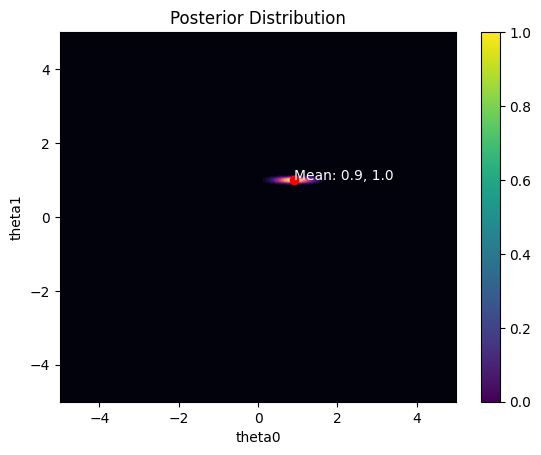

In [161]:
plt.title("Posterior Distribution")
plot_contour(unleaned_posterior)
plt.show()

In [162]:
prediction_dists_new = []
for i in range(n+1):
    prediction_dists_new.append(predictive_dist(X[i] , unlearned_posterior_mean , unlearned_posterior_cov , var_likelihood))

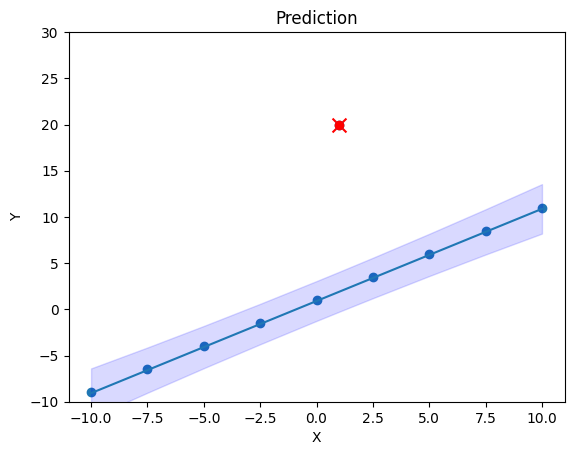

In [170]:
plt.scatter(x_outlier[0][1] , y_outlier , color = 'red' , marker='x' , s=100)
plot_predictions(prediction_dists_new , X , Y)